<img src="images/logo_simple.png" alt="logo" width="400"/>

## Snippets de code 

Ces snippets de code vont vous permettre de gagner du temps dans la prise en main des ressources à disposition et de l'écosystème data d'île-de-France Mobilités. 

!pip install -r requirements.txt

## Sommaire

- [Appel d'API PRIM — Instanciation API](#appel-dapi-prim)
  - [Appel d'API PRIM — Exemple de calcul d'itinéraire](#exemple-de-demande-de-calcul-ditinéraire)
  - [Appel d'API PRIM — Passage du token et endpoint](#passage-du-token-et-appel-dun-endpoint)
  - [Nomenclature pour les appels API](#nomenclature-pour-les-appels-api)
    - [Code ligne vers identifiant SIRI](#code-ligne-vers-identifiant-de-ligne-siri)
    - [Code arrêt vers identifiant d'arrêt SIRI](#code-arrêt-vers-identifiant--darrêt-siri)
- [Onyxia — Connexion au stockage](#connexion-au-stockage)
  - [Lecture S3](#lecture-dun-fichier-depuis-lespace-de-stockage-partagé-vers-une-dataframe-pandas)
  - [Ecriture S3](#ecriture-dun-fichier-depuis-une-dataframe-pandas-vers-lespace-de-stockage-partagé)
- [Utilisation de modèles ouverts sur Hugging Face en local](#utilisation-de-modèles-ouverts-sur-hugging-face-en-local)

*Cliquez sur un titre (si votre visualiseur de notebook supporte les ancres) pour accéder à la section.*

### Appel d'API PRIM

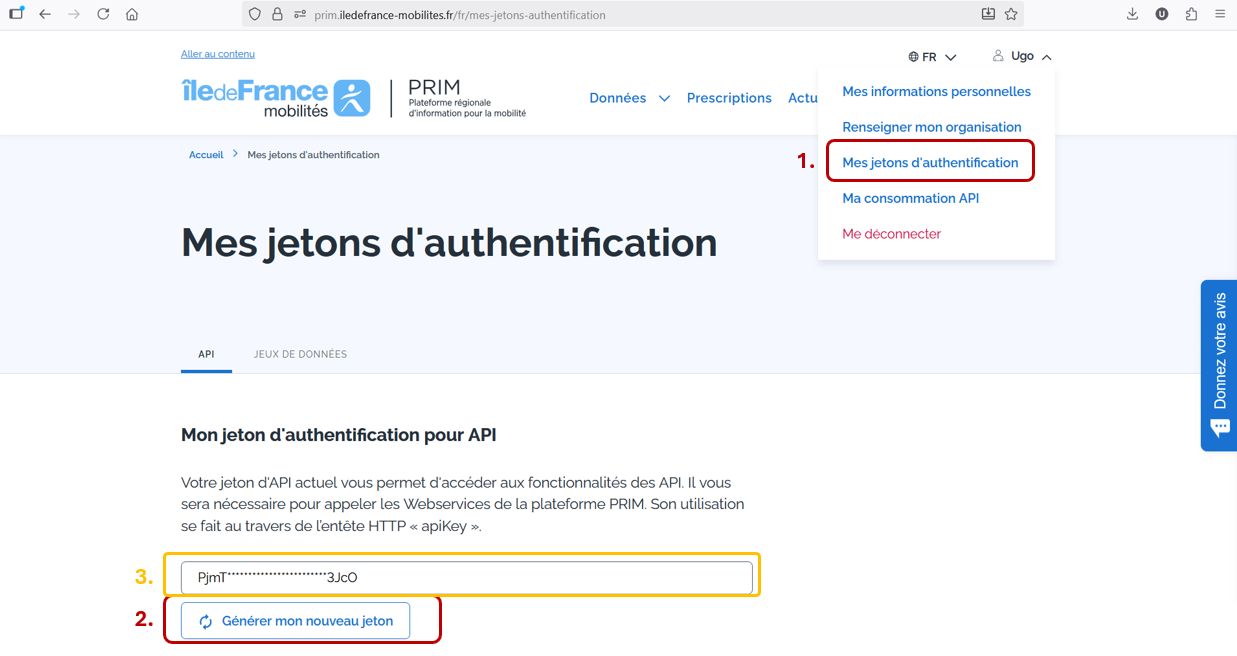

In [ ]:
import requests
import json
import pandas as pd

# Informations API
API_BASE = "https://prim.iledefrance-mobilites.fr/marketplace/"
API_KEY = "your-api-key"  # remplacer par votre clé
HEADERS = {"Accept": "application/json", "apikey": API_KEY}

#### Exemple de demande de calcul d'itinéraire

In [ ]:
API_URL = API_BASE + "v2/navitia/journeys"

# Coordonnées (lon, lat) — des chaînes conviennent pour le tutoriel
ORIGIN_LON = "2.33792"
ORIGIN_LAT = "48.85827"
DEST_LON = "2.3588523"
DEST_LAT = "48.9271087"

# Date/heure pour le trajet (format : YYYYMMDDTHHMMSS)
TRIP_DATETIME = "20241121T073000"

# Construire l'URL (Navitia attend lon;lat encodé en lon%3B%20lat)
FROM_PARAM = f"{ORIGIN_LON}%3B%20{ORIGIN_LAT}"
TO_PARAM = f"{DEST_LON}%3B%20{DEST_LAT}"
URL = f"{API_URL}?from={FROM_PARAM}&to={TO_PARAM}&datetime={TRIP_DATETIME}"

# Afficher l'URL pour que le lecteur voie comment elle est construite
print("Aperçu de l'URL Navitia :")
print(URL)

In [ ]:
# Exécuter la requête inline (style tutoriel simple)
try:
    resp = requests.get(URL, headers=HEADERS)
    print("Statut HTTP :", resp.status_code)

    if resp.status_code == 200:
        data = resp.json()
        # Aplatir le JSON de premier niveau pour inspection
        df = pd.json_normalize(data)
        print("Clés de premier niveau :", list(data.keys()))

        # Si des 'journeys' sont présents, inspecter le premier
        if isinstance(data, dict) and data.get("journeys"):
            print("Premier trajet (aplatit) :")
            display(pd.json_normalize(data["journeys"][0]))
        else:
            print("Aucun trajet ('journeys') retourné dans la réponse.")
    else:
        print("Réponse non-200, corps (400 premiers caractères) :")
        print(resp.text[:400])

except Exception as e:
    print("La requête a échoué :", e)

#### Passage du token et appel d'un endpoint

In [ ]:
ID_LIGNE = "C01742"  # Exemple : RER A
API_URL = f"{API_BASE}general-message?LineRef=STIF%3ALine%3A%3A{ID_LIGNE}%3A"

# Affichage rapide pour vérification (utile en mode tutoriel)
print("Requête vers :", API_URL)

# --- Requête inline et traitement minimal ---
try:
    response = requests.get(API_URL, headers=HEADERS)
    print("Statut HTTP :", response.status_code)

    if response.status_code == 200:
        # Parser le JSON et l'afficher (ou l'extraire selon le besoin)
        json_data = response.json()
        print("Réponse JSON (extrait) :")
        # Affiche la structure JSON (ou un extrait) pour inspection
        print(json.dumps(json_data, indent=2, ensure_ascii=False)[:1000])
    else:
        print("Échec de la requête HTTP. Statut :", response.status_code)
        print("Réponse (début) :", response.text[:400])

except Exception as e:
    print("Une erreur s'est produite lors de l'appel HTTP :", str(e))

#### Nomenclature pour les appels API
##### Code ligne vers identifiant de ligne SIRI

In [ ]:
# Conversion de l'id_ligne du référentiel des lignes en id compatible avec les API
# /!\ les "deux points" finaux sont indispensables

code_ligne_idfm = "C01742"  # RER A
id_ligne_idfm = "STIF:Line::{id_ligne_idfm}:"

##### Code arrêt vers identifiant  d'arrêt SIRI
_Note : les identifiant d'arrêts à prendre en compte sont en général les id de zones d'arrêt._

In [ ]:
# Conversion de ZdAId du référentiel des arrêts en id compatible avec les API
# /!\ les "deux points" finaux sont indispensables

code_zone_arret_idfm = "42135"  # Les Dix Arpents
id_arret_idfm = "STIF:monomodalStopPlace::{code_zone_arret_idfm}:"

### Onyxia
#### Connexion au stockage

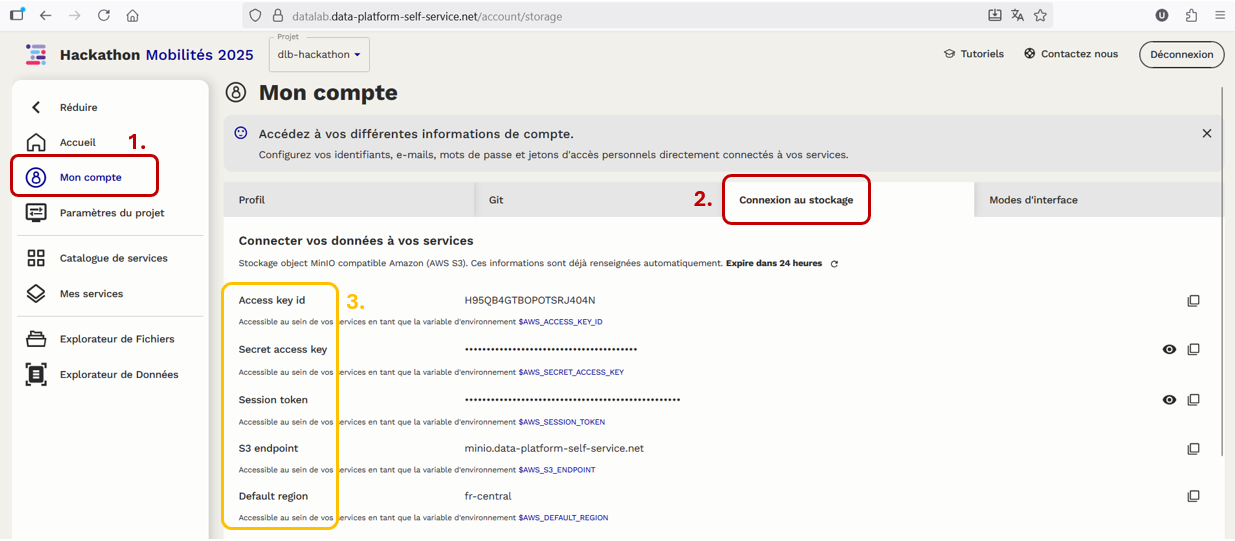

In [ ]:
import io
import boto3
import pandas as pd

# Remplacer par vos propres informations d'identification et paramètres
ACCESS_KEY = "your-access-key"
SECRET_KEY = "your-secret-key"
SESSION_TOKEN = "your-session-token"
REGION = "your-region"
ENDPOINT_URL = "your-endpoint-url"

BUCKET = "dlb-hackathon"

s3 = boto3.client(
    "s3",
    endpoint_url="https://" + ENDPOINT_URL,
    aws_access_key_id=ACCESS_KEY,
    aws_secret_access_key=SECRET_KEY,
    aws_session_token=SESSION_TOKEN,
    region_name=REGION,
)

my_bucket = s3.Bucket(BUCKET)
for my_bucket_object in my_bucket.objects.all():
    print(my_bucket_object)

#### Lecture d'un fichier depuis l'espace de stockage partagé vers une dataframe pandas

In [ ]:
FILE_KEY_S3 = "/datasets-diffusion/ascenseurs_historique_etat/RELEVES_ETATS_ASCENSEURS_SNCF_RATP_2021-2024.csv"

response = s3.get_object(Bucket=BUCKET, Key=FILE_KEY_S3)
status = response.get("ResponseMetadata", {}).get("HTTPStatusCode")

if status == 200:
    df = pd.read_csv(response.get("Body"))
    print("Aperçu des données importées :")
    print(df.head())
else:
    print(f"Erreur lors de l'importation des données. Statut HTTP: {status}")

#### Ecriture d'un fichier depuis une dataframe pandas vers l'espace de stockage partagé

In [ ]:
FILE_KEY_S3 = "tests_io_onyxia/books.csv"
books_df = pd.DataFrame(
    data={"Title": ["Book I", "Book II", "Book III"], "Price": [56.6, 59.87, 74.54]},
    columns=["Title", "Price"],
)

with io.StringIO() as csv_buffer:
    books_df.to_csv(csv_buffer, index=False)
    response = s3.put_object(Bucket=BUCKET, Key=FILE_KEY_S3, Body=csv_buffer.getvalue())

    status = response.get("ResponseMetadata", {}).get("HTTPStatusCode")
    if status == 200:
        print("Fichier écrit avec succès dans l'espace de stockage partagé.")
    else:
        print(f"Erreur lors de l'écriture du fichier. Statut HTTP: {status}")

### Utilisation de modèles ouverts sur Hugging Face en local

In [ ]:
from llama_cpp import Llama

# Cette instruction minimale permet de sélectionner le modèle et son niveau de compression, le téléchargement le paramétrage et la mise en mémoire (CPU), sont automatiques :
llm = Llama.from_pretrained(
    repo_id="bartowski/gemma-2-2b-it-GGUF",  # Plus gros dépôt de LLM libres de Hugging face : https://huggingface.co/bartowski
    filename="gemma-2-2b-it-Q6_K_L.gguf",  # Attention a prendre des modèles de taille <= 6Go pour des performances raisonnables, pas de garantie de fonctionnement au delà
    n_ctx=4096,
    verbose=False,
)

# Une fois le LLM chargé (environ une minute par Go), il peut être appelé, via une fonction *completion, ici pour un chatbot :
llm_response = llm.create_chat_completion(
    messages=[
        {
            "role": "user",
            "content": "###SYSTEM : You are the Capital assistant. I give you a country, you give me the capital and try to retrieve the country iso code. ### FORMAT : Capital=<name of the Capital> CODE=<ISO CODE 2 CHARS>",
        },
        {
            "role": "assistant",
            "content": "OK, I understand. If you say France, i say Capital=Paris CODE=FR",
        },
        {"role": "user", "content": "Germany"},
    ]
)

# La réponse du LLM est pleine de métadonnées, mais le message texte peut être extrait de cette manière simple :
print(llm_response["choices"][0]["message"]["content"])